<a href="https://colab.research.google.com/github/syamkakarla98/Hyperspectral_Image_Analysis_Simplified/blob/master/Articles/Hyperspectral_Image_Analysis%E2%80%8A_%E2%80%8AClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indian Pines Satellite Image Analysis - Classification

You can use this notebook to write the ML pipeline for the classification of Indian pines based on the analysis of satellite images or you can create a folder with different files associated to the different steps of the ML pipeline.

## Import Libraries

In [1]:
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#import Random forest classifiers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## Read the Data

In [3]:
from scipy.io import loadmat

def read_HSI():
  X = loadmat('data/Indian_pines_corrected.mat')['indian_pines_corrected']
  y = loadmat('data/Indian_pines_gt.mat')['indian_pines_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y

X, y = read_HSI()

X shape: (145, 145, 200)
y shape: (145, 145)


In [4]:
X.shape

(145, 145, 200)

In [5]:
y.max()

16

In [6]:
y.min()

0

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC_1', y='PC_2', hue='label', data=df_pca)
plt.title('Scatter Plot of PC_1 vs PC_2 colored by class labels')
plt.show()

# Box plots for PC_1 and PC_2 across different classes
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='PC_1', data=df_pca)
plt.title('Box Plot of PC_1 across different classes')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='PC_2', data=df_pca)
plt.title('Box Plot of PC_2 across different classes')
plt.show()

NameError: name 'df_pca' is not defined

<Figure size 1000x600 with 0 Axes>

### Visualize Bands

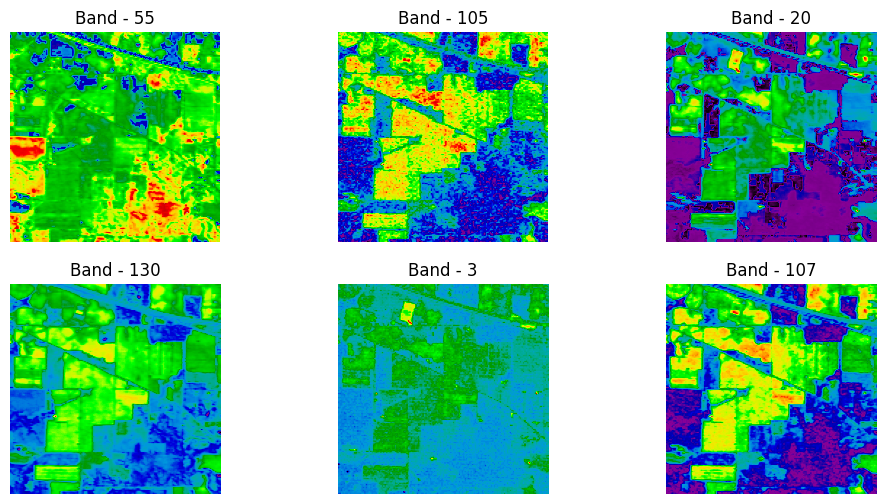

In [8]:
fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.savefig('IP_Bands.png')

### Visualize the Ground Truth

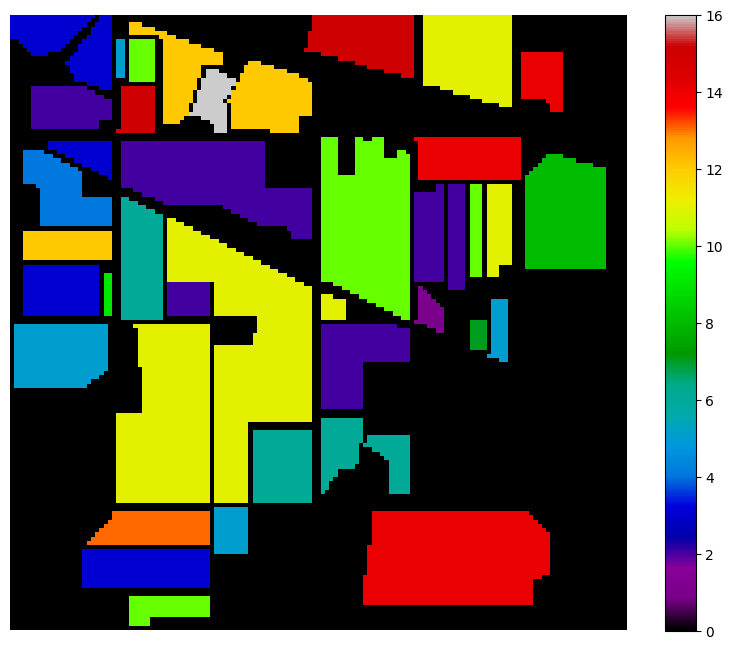

In [9]:
plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_GT.png')
plt.show()

## Convert the dataset into csv 

In [10]:
import pandas as pd
import numpy as np

def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  df.to_csv('Dataset.csv')
  return df
  
df = extract_pixels(X, y)

In [11]:
X.min()

955

# EDA 

Perform exploratory data analysis on the tabular data

Basic Statistics:
             band_1        band_2        band_3        band_4        band_5  \
count  21025.000000  21025.000000  21025.000000  21025.000000  21025.000000   
mean    2957.363472   4091.321237   4277.502259   4169.956671   4516.678668   
std      354.918708    230.390005    257.827640    280.761254    346.035984   
min     2560.000000   2709.000000   3649.000000   2810.000000   3840.000000   
25%     2602.000000   3889.000000   4066.000000   3954.000000   4214.000000   
50%     2780.000000   4106.000000   4237.000000   4126.000000   4478.000000   
75%     3179.000000   4247.000000   4479.000000   4350.000000   4772.000000   
max     4536.000000   5744.000000   6361.000000   6362.000000   7153.000000   

             band_6        band_7        band_8        band_9       band_10  \
count  21025.000000  21025.000000  21025.000000  21025.000000  21025.000000   
mean    4790.595149   4848.317574   4714.732509   4668.904828   4439.065541   
std      414.382138    469.247667

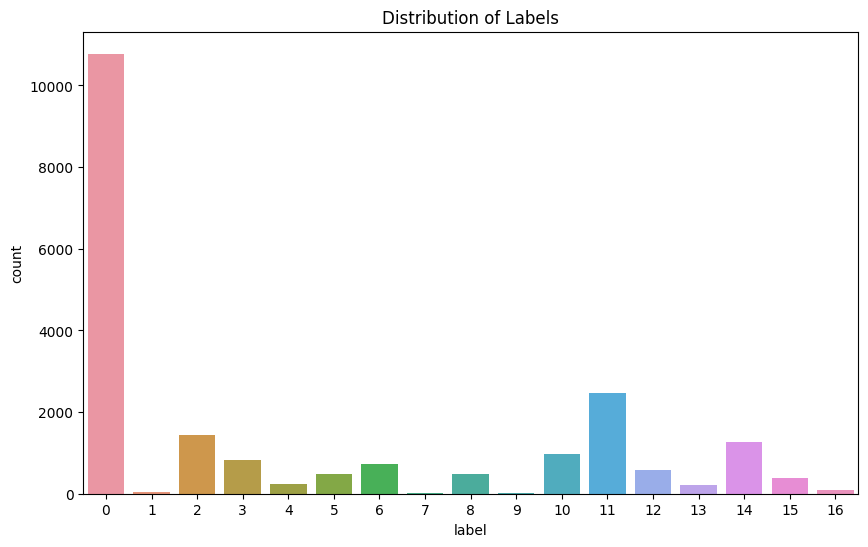

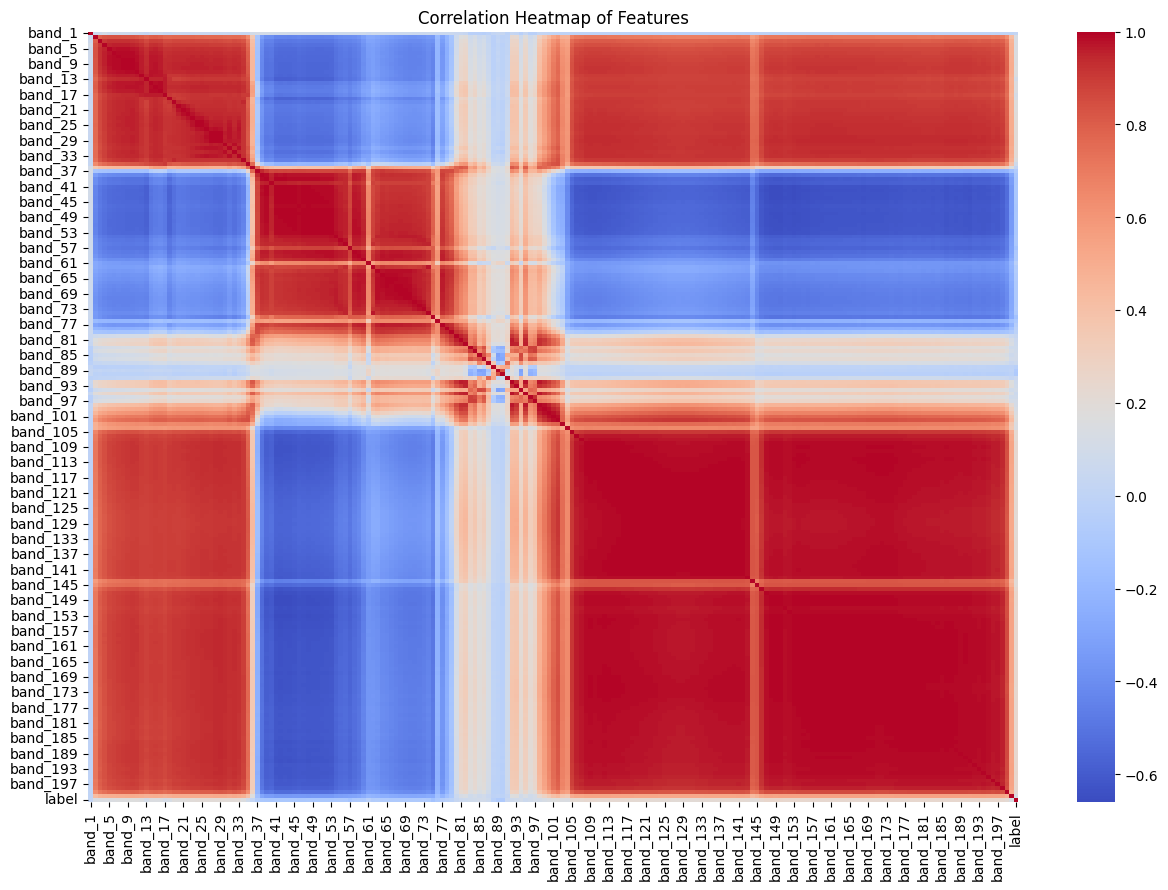

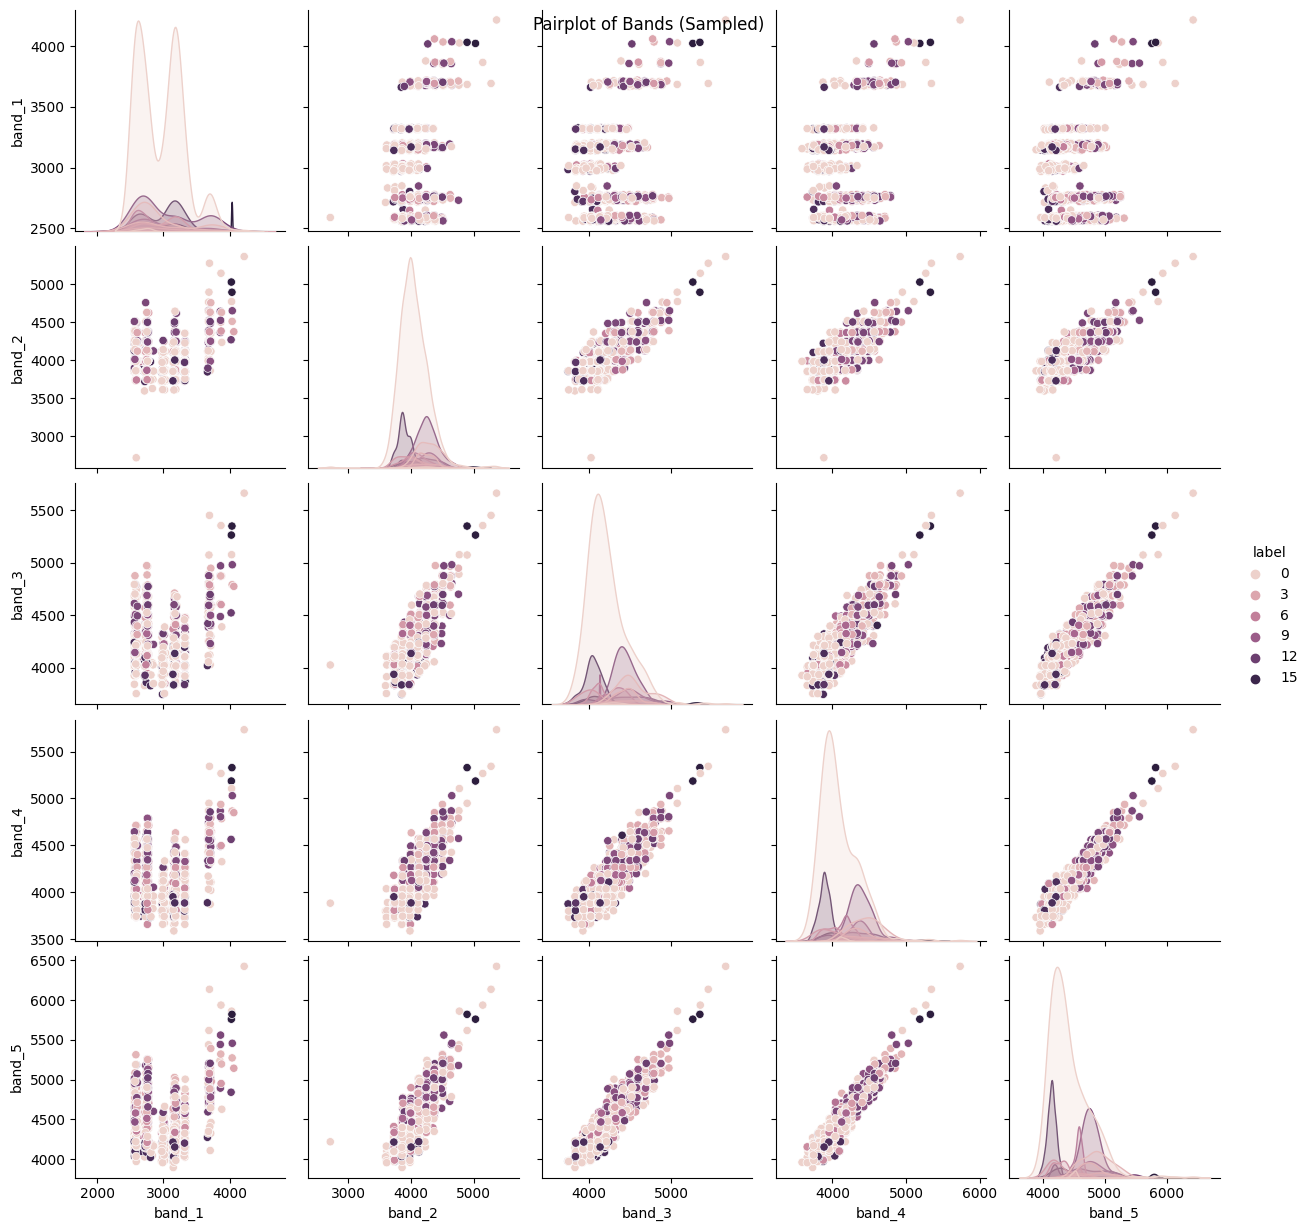

In [12]:
# Reshape X to a 2D array (rows: pixels, columns: bands)
X_reshaped = X.reshape(-1, X.shape[2])

# Create a DataFrame with flattened features and labels
columns = [f'band_{i}' for i in range(1, X.shape[2] + 1)]
df = pd.DataFrame(data=X_reshaped, columns=columns)
df['label'] = y.flatten()

# Display basic statistics
print("Basic Statistics:")
print(df.describe())

# Visualize the distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Labels')
plt.show()

# Correlation heatmap of features
plt.figure(figsize=(15, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Features')
plt.show()

# Pairplot of a subset of bands (e.g., first 5 bands)
sns.pairplot(df.sample(n=1000, random_state=42), hue='label', vars=columns[:5])
plt.suptitle('Pairplot of Bands (Sampled)')
plt.show()

## Principal Component Analysis(PCA)


STEPS

1. Estimate the basis of Principal components

2. Plot the cumulative explained variance associated with Principal components VS Number of components.

3. Select acordingly the no.of components for PCA projection

4. Reconstruct the images associated to the different bands using the selected principal components

200
(21025, 200)
955
9604
-7.642090293989591
8.992655544253978
[[ 1.05739847e+01  4.21271342e+00  1.88367770e-01 ...  1.12864007e-02
  -4.01025776e-02 -4.15130517e-04]
 [ 1.31577074e+01 -1.95441227e+00  1.54366545e-01 ...  2.65921816e-02
  -2.19664497e-02  6.96103653e-03]
 [ 1.40703503e+01 -3.84390553e+00  1.00992112e-01 ... -6.90078898e-03
   1.22444325e-04 -6.61943587e-03]
 ...
 [-1.53038839e+01 -3.54400039e+00  6.41085446e-01 ...  7.30670753e-03
   1.43517837e-02 -2.41528928e-02]
 [-1.53757104e+01  1.14070000e+00  1.32109095e+00 ...  6.95780965e-03
   4.09411728e-02 -2.15839985e-03]
 [-1.53331740e+01  1.81979262e-01  1.24221297e+00 ...  3.97695833e-04
   3.73716299e-03  1.84738086e-02]]
            PC_1      PC_2      PC_3      PC_4      PC_5      PC_6      PC_7  \
0      10.573985  4.212713  0.188368 -0.453512  0.708530 -1.269551  0.557866   
1      13.157707 -1.954412  0.154367  1.221876  1.546592 -0.789850 -1.345252   
2      14.070350 -3.843906  0.100992  2.504653  1.606242 -1.2

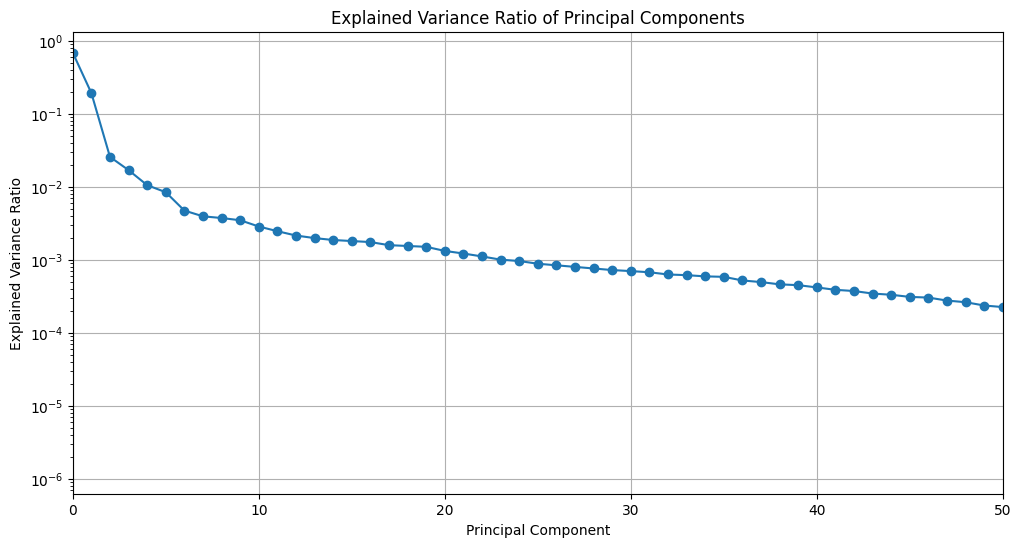

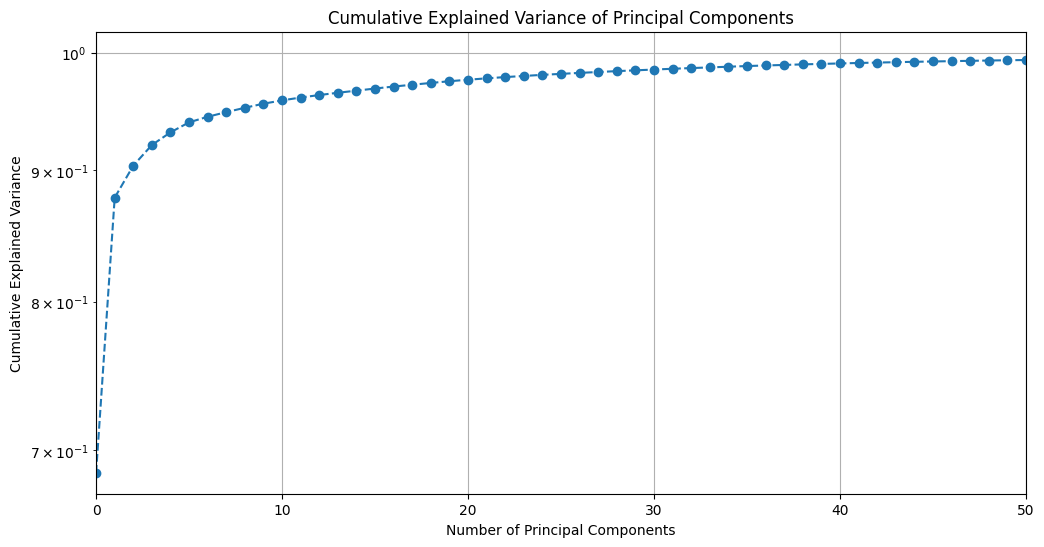

n. components:  8


In [16]:
#Reshape X to a 2D array (rows = pixels, columns = bans)
from sklearn.decomposition import PCA
print(X.shape[2])
X_reshaped = X.reshape(-1,X.shape[2])
print(X_reshaped.shape)
print(X_reshaped.min())
print(X_reshaped.max())
#Standardize the features 
X_standardized = (X_reshaped-X_reshaped.mean(axis=0))/X_reshaped.std(axis=0)
print(X_standardized.min())
print(X_standardized.max())
#apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_standardized)
print(X_pca)
#DataFrame creation for labels and reduction
columns=[f'PC_{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(data=X_pca,columns=columns)
df_pca['label']=y.flatten()
print(df_pca)
# Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio
plt.figure(figsize=(12, 6))
plt.yscale('log')
plt.plot(explained_variance_ratio, marker='o')
plt.title('Explained Variance Ratio of Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.xlim((0,50))
plt.show()

# Plot cumulative explained variance
plt.figure(figsize=(12, 6))
plt.yscale('log')
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.xlim((0,50))
plt.show()

# number of principal components from explained variance ratio and cumulative explained variance 
n_components = 8
print("n. components: ",n_components)

# LDA (wip) 


## Plot reconstructed images in different bands

In [2]:
#fig = plt.figure(figsize = (20, 10))



#plt.savefig('IP_PCA_Bands.png')

In [15]:
# saving to .csv
q.to_csv('IP_40_PCA.csv', index=False)

## Classification with RF (optional: comparison with other classifiers)

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Loading Plotting Utilities
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from mlxtend.plotting import plot_decision_regions
import numpy as np

# Initializing Classifiers
clf1 = LogisticRegression(random_state=1, solver='lbfgs')
clf2 = RandomForestClassifier(n_estimators=100, 
                              random_state=1)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

#Use the names below for the classes sorted


names = ['Alfalfa','Corn-notill', 'Corn-mintill','Corn','Grass-pasture','Grass-trees',
'Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill',
'Soybean-clean', 'Wheat','Woods','Buildings Grass Trees Drives','Stone Steel Towers']


#SPLIT DATA in TRAINING and testing
X=X_pca
y=
#Define classifier

#Fit and predict
#ypred = classifier.predict(X_test)

In [3]:
#PLOT THE CONFUSION MATRIX Associate to the classifier

#data = confusion_matrix(y_test, ypred)
#df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
#plt.savefig('cmap.png', dpi=300)

In [1]:
#print(classification_report(y_test, ypred, target_names = names))

## Classification Map

In [4]:
#Use the function below to produce the classification map


def reconstruct_classification_map(q, classifier):
    l=[]
    for i in range(q.shape[0]):
      if q.iloc[i, -1] == 0:
        l.append(0)
      else:
        l.append(classifier.predict(q.iloc[i, :-1].values.reshape(1, -1)))
    return l


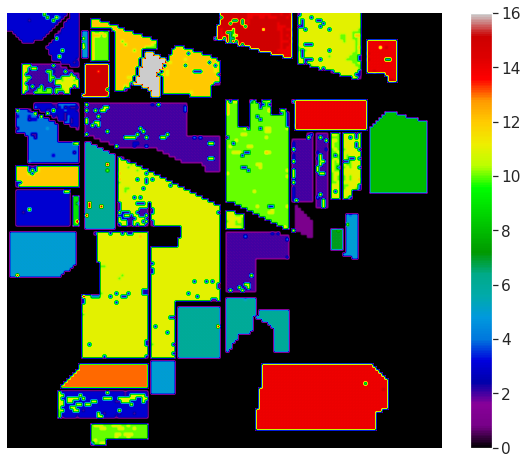

In [129]:
clmap = np.array(l).reshape(145, 145).astype('float')
plt.figure(figsize=(10, 8))
plt.imshow(clmap, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_cmap.png')
plt.show()



---



---

